## Setup

In [43]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "Chapter3"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

## MNIST

In [2]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist
"""
DESCR: discribing the dataset
data: an array with one row per instance and one column per feature
target: an array with the labels
"""

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape # 784 = 28*28 pixels
# each fearture represents one pixel's intensity, from 0(white) to 255(black)

(70000, 784)

In [4]:
y.shape

(70000,)

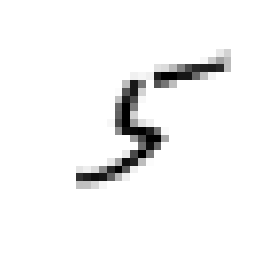

In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[35000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off")

plt.show()

In [7]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [8]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

Saving figure digits_plot


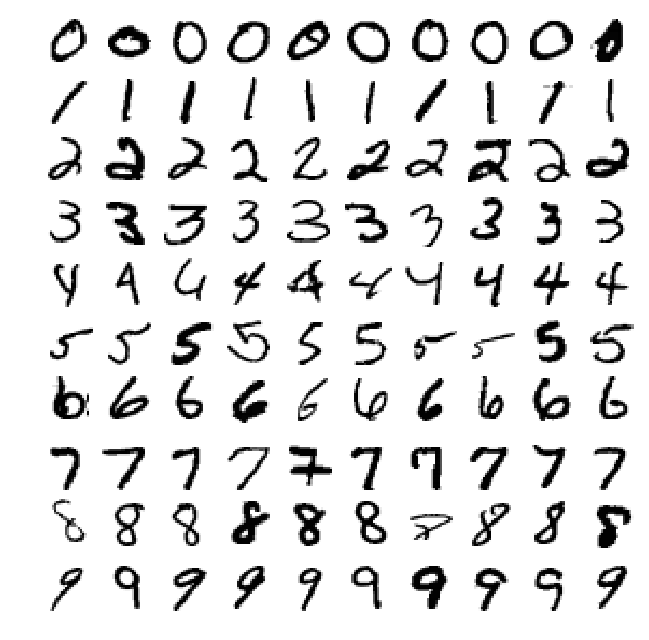

In [11]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
save_fig("digits_plot")
plt.show()

In [12]:
y[35000]

5.0

In [13]:
# split the data into train and test
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [14]:
# shuffle the training set
"""
This will guarantee that all cross-validation folds will be similar.
Moreover, some learning algorithms are sensitive to the order of the training instances,
and they perform poorly if they get maney similar instances in a row.
Shuffling the dataset ensures that this won't happen.

Shuffling may be a bad idea in some contexts;
e.g. time series data (such as stock market prices or weather conditions)
"""
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Binary classifier

In [15]:
# 5-detector
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [16]:
# Stochastic Gradient Descent (SGD)
# This classifier has the advantage of being capable of handling very large datasets efficiently
from sklearn.linear_model import SGDClassifier

# If we want reproducible results, we should set the random_state parameter
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [17]:
sgd_clf.predict([some_digit])

array([ True], dtype=bool)

In [18]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.9502 ,  0.96565,  0.96495])

In [19]:
"""
Occasionally we will need more control over the cross-validation process than what Scikit-Learn provides off-the-shelf.
In these cases, we can implement cross-validation by ourselves.
"""
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9502
0.96565
0.96495


In [20]:
# Let's look at a very dumb classifier that just classifies every single image in the "not-5" class
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [21]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")
"""
this model has over 90% accuracy!
This is simply because only about 10% of the images are 5s, so if we always guess that an image is not a 5,
we will be right about 90% of the time.
"""

array([ 0.909  ,  0.90715,  0.9128 ])

In [22]:
from sklearn.model_selection import cross_val_predict

"""
cross_val_predict() performs K-fold cross-validation, but instead of returning the evaluation scores,
it returns the predictions made on each test fold.
"""
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [23]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)
"""
Each row in a confusion matrix represents an actual class,
while each column represents a predicted class.

The first row considers non-5 images (the negative class):
53272 were correctly classified s non-5s (true negatives),
while 1307 were wrongly classified as 5s (false positives).

The second row considers the images of 5s (the positive class):
1077 were wrongly classified as non-5s (false negatives),
while 4344 were correctly classified as 5s (true positives).
"""

array([[53272,  1307],
       [ 1077,  4344]])

In [24]:
# A perfect classifier would have nonzero values only on its main diagonal
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [27]:
from sklearn.metrics import precision_score, recall_score
"""
precision = TP / (TP + TP) # TP: true positives, FP: false positives
"""
precision_score(y_train_5, y_train_pred) # 4344 / (4344 + 1307)

0.76871350203503808

In [26]:
"""
recall = TP / (TP + FN) # FN: false negatives
"""
recall_score(y_train_5, y_train_pred) # 4344 / (4344 + 1077)

0.80132816823464303

In [28]:
"""
F1 = 2 * (precision * recall)/(precision + recall) = TP / (TP + (FN + FP)/2)
"""
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred) # 4344 / (4344 + (1077 + 1307)/2)

0.78468208092485547

In [29]:
"""
decision_function() returns a score for each instance, 
and then make predictions based on those scores using any threshold we want.
"""
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([ 43349.73739616])

In [30]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [31]:
y_some_digit_pred

array([ True], dtype=bool)

In [32]:
# The SGDClassifier uses a threshold equal to 0
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False], dtype=bool)

In [33]:
# We want the model to return decision scores instead of predictions:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [34]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Saving figure precision_recall_vs_threshold_plot


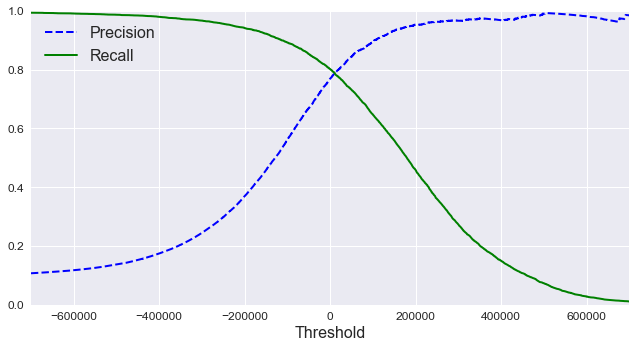

In [38]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(9, 5))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
save_fig("precision_recall_vs_threshold_plot")
plt.show()

In [39]:
y_train_pred_90 = (y_scores > 70000)

In [40]:
precision_score(y_train_5, y_train_pred_90)

0.86592051164915484

In [41]:
recall_score(y_train_5, y_train_pred_90)

0.69931746910164172

Saving figure precision_vs_recall_plot


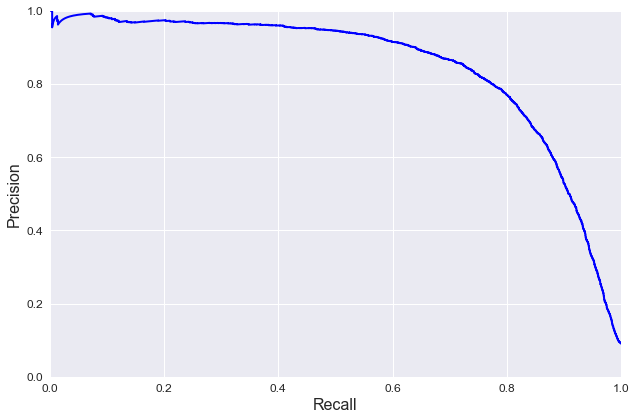

In [42]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(9, 6))
plot_precision_vs_recall(precisions, recalls)
save_fig("precision_vs_recall_plot")
plt.show()

## ROC curves

In [44]:
# ROC (receiver operating characteristic) curve
"""
FPR: the ratio of negative instances that are incorrectly classified as positive.
TNR(specificity): the ratio of negative instances that are correctly classified as negative.
The ROC curve plots the true positive rate (recall) against the false positive rate (1 - specificity).
"""
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Saving figure roc_curve_plot


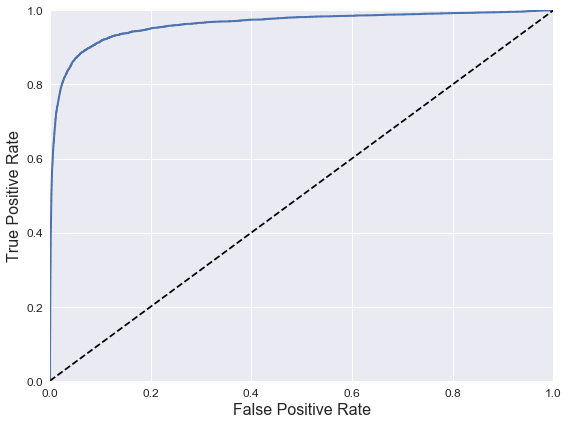

In [49]:
"""
The dotted line represents the ROC curve of purely random classifier;
a good classifier stays as far away from that line as posssible (toward the top-left corner.)
"""
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
save_fig("roc_curve_plot")
plt.show()

In [48]:
"""
One way to compare classifiers is to measure the area under the curve (AUC).
A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will
have a ROC AUC equal to 0.5.

We should prefer the PR curve whenever the positive class is rare or when we care about the false positives
than the false negatives, and the ROC curve otherwise.
"""

from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.96244965559671547

In [51]:
"""
RandomForestClassifier does not have a decision_function() method.
Instead it has a predict_proba() method.
"""
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [52]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

Saving figure roc_curve_comparison_plot


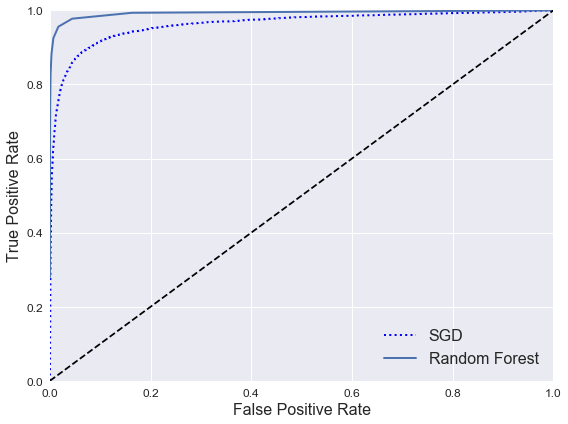

In [53]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [54]:
roc_auc_score(y_train_5, y_scores_forest)

0.99312433660038291

In [55]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.98529734474434938

In [56]:
recall_score(y_train_5, y_train_pred_forest)

0.82826046854823832

## Multiclass classification

In [57]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([ 5.])

In [58]:
# The highest score is indeed the one corresponding to class 5
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-409943.35559323,  -64362.36942148, -199023.49268514,
        -282266.44093229,  -91499.56921685,   43349.73739616,
        -188385.7510118 , -317793.04941277,   12000.12030244,
        -404406.99055027]])

In [59]:
np.argmax(some_digit_scores)

5

In [60]:
sgd_clf.classes_

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

In [61]:
sgd_clf.classes_[5]

5.0

In [62]:
"""
If we want to force ScikitLearn to use one-versus-one or one-versus-all, we can use the OneVsOneClassifier
or OneVsRestClassifier classes.
"""
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([ 5.])

In [63]:
len(ovo_clf.estimators_)

45

In [64]:
# Training a RandomForestClassifier
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([ 5.])

In [65]:
forest_clf.predict_proba([some_digit])

array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]])

In [66]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([ 0.84063187,  0.84899245,  0.86652998])

In [67]:
# Simply scaling the inputs increases accuracy
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([ 0.91011798,  0.90874544,  0.906636  ])

In [68]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5725,    3,   24,    9,   10,   49,   50,   10,   39,    4],
       [   2, 6493,   43,   25,    7,   40,    5,   10,  109,    8],
       [  51,   41, 5321,  104,   89,   26,   87,   60,  166,   13],
       [  47,   46,  141, 5342,    1,  231,   40,   50,  141,   92],
       [  19,   29,   41,   10, 5366,    9,   56,   37,   86,  189],
       [  73,   45,   36,  193,   64, 4582,  111,   30,  193,   94],
       [  29,   34,   44,    2,   42,   85, 5627,   10,   45,    0],
       [  25,   24,   74,   32,   54,   12,    6, 5787,   15,  236],
       [  52,  161,   73,  156,   10,  163,   61,   25, 5027,  123],
       [  43,   35,   26,   92,  178,   28,    2,  223,   82, 5240]])

In [69]:
def plot_confusion_matrix(matrix):
    """If we prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

Saving figure confusion_matrix_plot


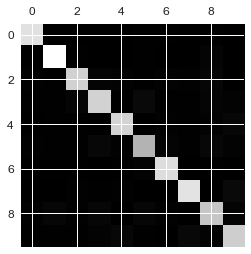

In [70]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

In [71]:
# Focus the plot on the errors
"""
First, we need to devide each value in the confusion value matrix by the number of images in the corresponding class,
so we can compare error rates instead of absolute numbor of errors.
"""
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Saving figure confusion_matrix_errors_plot


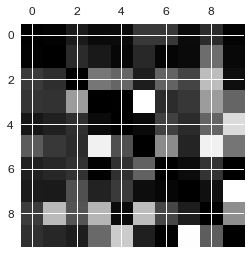

In [72]:
# fill the diagonal with zeros to keep only the errors
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

Saving figure error_analysis_digits_plot


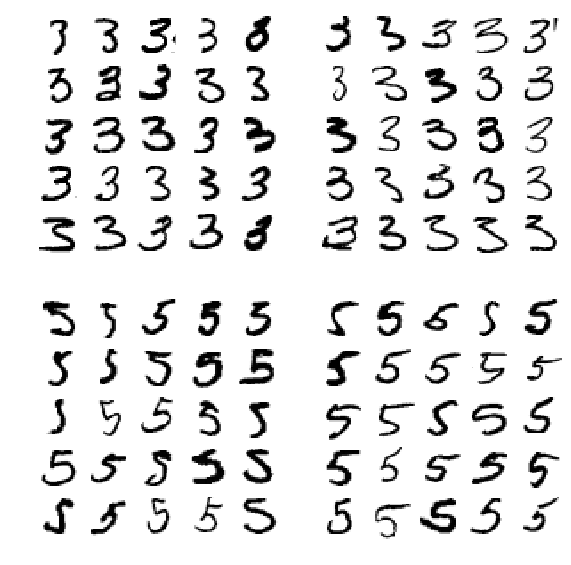

In [73]:
"""
The left show digits classified as 3s, and the right show images classified as 5s.
The bottom-left and top-right blocks are wrongly classified.
"""
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

## Multilabel classification

In [74]:
# A classification system that outputs multiple binary labels is called a multilabel classification system
"""
This creats a y_multilabel array containing two target labels for each digit image:
the first indicates whether or not the digit is large (7, 8 or 9)
the second indicates whether or not it is odd.
"""
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [ ]:
knn_clf.predict([some_digit])

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")